In [1]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("glock", {}, "/home/m/glock/glock_person_anns/train.json", "/home/m/glock/glock_person_imgs")
register_coco_instances("glock_test", {}, "/home/m/glock/annotations_glock/test.json", "/home/m/glock/test")

from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 10000})

In [2]:
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog

In [3]:
dataset_dicts = DatasetCatalog.get("glock")
glock_metadata = MetadataCatalog.get("glock")


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [4]:
import matplotlib.pyplot as plt
import random
from detectron2.utils.visualizer import Visualizer
import cv2

/home/m/glock/glock_person_imgs/000000548939.jpg


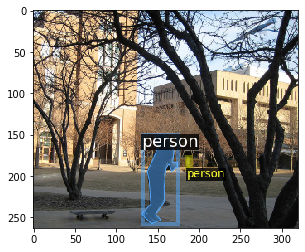

In [56]:
for d in random.sample(dataset_dicts, 1):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=glock_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [57]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [58]:
from datetime import datetime
import os

In [59]:
cfg = get_cfg()

# cfg.OUTPUT_DIR = "tboard_logs/test_test_2020-02-22T23:14/"
cfg.OUTPUT_DIR = f"./tboard_logs/glock_{datetime.now().isoformat().rsplit(':', 1)[0]}/"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("glock",)
cfg.DATASETS.TEST = ("glock_test",)

cfg.DATALOADER.NUM_WORKERS = 4

# cfg.INPUT.FORMAT = "RGB"
cfg.INPUT.FORMAT = "BGR"
'''
cfg.INPUT.MIN_SIZE_TRAIN = (256,)
cfg.INPUT.MIN_SIZE_TEST = (256,)
cfg.INPUT.MAX_SIZE_TRAIN = (1200,)
cfg.INPUT.MAX_SIZE_TEST = (1200,)
'''
cfg.MODEL.META_ARCHITECTURE = 'RetinaNet'
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.MODEL.RETINANET.NUM_CLASSES = 3
cfg.MODEL.BACKBONE.FREEZE_AT=3
# cfg.MODEL.PIXEL_MEAN = [103.53, 116.28, 123.675, 187.153] #ostatnia wartość wpisana z palca
cfg.MODEL.PIXEL_STD =  [1.0, 1.0, 1.0]#, 1.0]
cfg.MODEL.PIXEL_MEAN = [68.60176277048289, 90.37255792238817, 99.04053918695983][::-1]
#, 187.12327778336686]
# cfg.MODEL.PIXEL_STD = [25.05072945688351, 22.96708310183466, 13.27640256812483, 10.55706656507702]


cfg.SOLVER.IMS_PER_BATCH = 2 # 32
cfg.SOLVER.BASE_LR = 0.001 # 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 100000  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical data

cfg.SOLVER.WARMUP_ITERS = 1_000
cfg.SOLVER.GAMMA = 0.3
cfg.SOLVER.STEPS = (100_000, 200_000, 300_000, 400_000, 500_000)

cfg.SOLVER.CHECKPOINT_PERIOD = 4000


# cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)

cfg.TEST.EVAL_PERIOD = 1_000 # 5000 #200
cfg.TEST.DETECTIONS_PER_IMAGE = 10

cfg.VIS_PERIOD = 10000

Loading config /home/m/.local/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [60]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open(cfg.OUTPUT_DIR + "/config.yml", "w") as f:
    f.write(cfg.dump())

In [61]:
from detectron2.evaluation.coco_evaluation import COCOEvaluator
from detectron2.data import DatasetMapper
import detectron2.data.transforms as T
from detectron2.data import build_detection_train_loader
def build_sem_seg_train_aug(cfg):
    augs = [
        T.ResizeShortestEdge(
            cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
        )
    ]
    if cfg.INPUT.CROP.ENABLED:
        augs.append(
            T.RandomCrop_CategoryAreaConstraint(
                cfg.INPUT.CROP.TYPE,
                cfg.INPUT.CROP.SIZE,
                cfg.INPUT.CROP.SINGLE_CATEGORY_MAX_AREA,
            )
        )
    augs.append(T.RandomFlip())
    return augs
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator('glock_test', cfg, False)
    
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=build_sem_seg_train_aug(cfg))
        return build_detection_train_loader(cfg, mapper=mapper)
trainer = Trainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[10/06 10:16:26 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

[10/06 10:16:26 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[10/06 10:16:33 d2.data.datasets.coco]: Loading /home/m/glock/glock_person_anns/train.json takes 7.02 seconds.
WARNING [10/06 10:16:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/06 10:16:33 d2.data.datasets.coco]: Loaded 69970 images in COCO format from /home/m/glock/glock_person_anns/train.json
[10/06 10:16:36 d2.data.build]: Removed 0 images with no usable annotations. 69970 images left.
[10/06 10:16:38 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   person   | 257253       |   glock    | 3889         |   knife    | 7760       

Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (27, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (27,) in the model! You might want to double check if this is expected.


[10/06 10:16:41 d2.engine.train_loop]: Starting training from iteration 0
[10/06 10:16:46 d2.utils.events]:  eta: 6:16:40  iter: 19  total_loss: 0.877  loss_cls: 0.800  loss_box_reg: 0.102  time: 0.2222  data_time: 0.0135  lr: 0.000020  max_mem: 1716M
[10/06 10:16:49 d2.engine.hooks]: Overall training speed: 30 iterations in 0:00:06 (0.2332 s / it)
[10/06 10:16:49 d2.engine.hooks]: Total training time: 0:00:07 (0:00:00 on hooks)


KeyboardInterrupt: 

In [ ]:
from detectron2.utils.visualizer import ColorMode
import numpy as np
test_dataset_dicts = DatasetCatalog.get("glock_test")
glock_test_metadata = MetadataCatalog.get("glock_test")

In [ ]:
smpl = np.random.choice(test_dataset_dicts, 1)
for d in smpl:
    img = cv2.imread(d["file_name"], cv2.IMREAD_UNCHANGED)#[:, :, ::-1]
    visualizer = Visualizer(img[:,:,:3], metadata=glock_test_metadata, scale=0.75)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
confidence_threshold = 0.5
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = confidence_threshold 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = confidence_threshold 
cfg.DATASETS.TEST = ("glock_show", )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
for d in random.sample(test_dataset_dicts, 3):
    
    im = cv2.imread(d["file_name"])
    print(type(im), im.shape)
    #im = cv2.resize(im, (1131,597))
    print(type(im), im.shape)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1],
                   metadata=glock_test_metadata, 
                   scale=0.3)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())

In [ ]:
from detectron2.utils.visualizer import ColorMode
import os
glock_dir = "/home/m/Pulpit/klocki"
glock_files = os.listdir(glock_dir)
for d in glock_files:
    d = os.path.join(glock_dir, d)
    im = cv2.imread(d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1], scale=0.2, metadata=glock_metadata)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())